In [196]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from sa_decomp_layer import SADecompLayer


In [197]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [198]:
class SymAntiConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=(3,3), padding = 'VALID', strides = (1, 1), activation=None, use_bias = True, patch_size=8, decompose=True):
        super(SymAntiConv2D, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.padding = padding
        self.kernel_initializer = tf.initializers.GlorotUniform(seed=42)
        self.param_initializer = tf.initializers.GlorotUniform(seed=42)

        self.bias_initializer = tf.initializers.Zeros()
        self.strides = strides
        self.use_bias = use_bias
        self.w = None
        self.b_ss = None
        self.b_as = None
        self.b_sa = None
        self.b_aa = None

        self.patch_size =  patch_size
        self.decompose = decompose

    def build(self, input_shape):
        *_, n_channels = input_shape

        self.w = tf.Variable(
            initial_value=self.param_initializer(shape=(*self.kernel_size,
                                                         n_channels,
                                                         self.filters),
                                 dtype='float32'), trainable=True)
        


        if self.use_bias:
            if self.decompose == False:
                self.b_s = tf.Variable(
                    initial_value=self.bias_initializer(shape=(self.filters,), 
                                                        dtype='float32'),
                    trainable=True)

                self.b_a = tf.Variable(
                    initial_value=self.bias_initializer(shape=(self.filters,), 
                                                        dtype='float32'),
                    trainable=True)

                return


            self.b_ss = tf.Variable(
                initial_value=self.bias_initializer(shape=(self.filters,), 
                                                    dtype='float32'),
                trainable=True)

            self.b_sa = tf.Variable(
                initial_value=self.bias_initializer(shape=(self.filters,), 
                                                    dtype='float32'),
                trainable=True)

            self.b_as = tf.Variable(
                initial_value=self.bias_initializer(shape=(self.filters,), 
                                                    dtype='float32'),
                trainable=True)

            self.b_aa = tf.Variable(
                initial_value=self.bias_initializer(shape=(self.filters,), 
                                                    dtype='float32'),
                trainable=True)

    def call(self, inputs, training=None):

        filters = tf.reshape(self.w, (self.kernel_size[0],self.kernel_size[1],self.w.shape[-1]*self.w.shape[-2]))
        mat_flip_x = flip_left_right(filters)
        mat_flip_y = flip_up_down(filters)

        mat_flip_xy = flip_left_right(flip_up_down(filters))

        sum = filters + mat_flip_x + mat_flip_y + mat_flip_xy
        mat_sum_rot_90 = rot90(sum)

        sym_f = (sum + mat_sum_rot_90) / 8
        anti_f = filters-sym_f

        w_sym = tf.reshape(sym_f, self.w.shape)
        w_anti = tf.reshape(anti_f, self.w.shape)

        if self.decompose == False:

            x_s =  tf.nn.conv2d(inputs, filters=w_sym, strides=self.strides, 
                            padding=self.padding)
            x_a =  tf.nn.conv2d(inputs, filters=w_anti, strides=self.strides, 
                            padding=self.padding)

            if self.use_bias:
                #x_sym = x_sym + self.b_sym
                #x_anti = x_anti + self.b_anti
                x_s = x_s+self.b_s
                x_a = x_a+self.b_a


            return Concatenate()([x_s, x_a])

        sym_in, anti_in = SADecompLayer(w_size=self.patch_size)(inputs)




        x_ss =  tf.nn.conv2d(sym_in, filters=w_sym, strides=self.strides, 
                          padding=self.padding)
        x_sa =  tf.nn.conv2d(sym_in, filters=w_anti, strides=self.strides, 
                          padding=self.padding)
        x_as =  tf.nn.conv2d(anti_in, filters=w_sym, strides=self.strides, 
                          padding=self.padding)

        x_aa =  tf.nn.conv2d(anti_in, filters=w_anti, strides=self.strides, 
                          padding=self.padding)


        
        if self.use_bias:
            #x_sym = x_sym + self.b_sym
            #x_anti = x_anti + self.b_anti
            x_ss = x_ss+self.b_ss
            x_sa = x_sa+self.b_sa
            x_as = x_as+self.b_as
            x_aa = x_aa+self.b_aa


        return Concatenate()([x_ss, x_sa, x_as, x_aa])


In [199]:
from tkinter import S


input_net = Input((32, 32, 3))

'''sym_in, anti_in = SADecompLayer(w_size=8)(input_net)


y_s = SymAntiConv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu, decompose=False, padding='SAME', patch_size=3)(sym_in)
y_a = SymAntiConv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu, decompose=False, padding='SAME', patch_size=3)(anti_in)
y = layers.MaxPooling2D(pool_size=(2, 2))(Concatenate()([y_s, y_a])) 

y_s = SymAntiConv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu, decompose=False, padding='SAME', patch_size=3)(y)
y_a = SymAntiConv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu, decompose=False, padding='SAME', patch_size=3)(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(Concatenate()([y_s, y_a])) 
'''

y = SymAntiConv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu, padding='SAME', patch_size=3)(input_net)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

y = SymAntiConv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu, padding='SAME', patch_size=8)(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

y = SymAntiConv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu, padding='SAME', patch_size=8)(y)

y = layers.Flatten()(y)
y = layers.Dense(512, activation=tf.nn.gelu)(y)
y = layers.Dropout(0.1)(y)
y = layers.Dense(512, activation=tf.nn.gelu)(y)
y = layers.Dropout(0.1)(y)

output_net  = layers.Dense(100)(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()


Model: "model_241"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sym_anti_conv2d_66 (SymAnti  (None, 32, 32, 128)      992       
 Conv2D)                                                         
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 sym_anti_conv2d_67 (SymAnti  (None, 16, 16, 256)      73984     
 Conv2D)                                                         
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                                                    

In [200]:
batch_size = 256
epochs = 100
model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


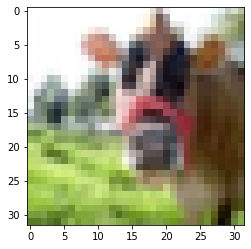

In [201]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])


In [202]:
def rotateDataset(x,y, maxRot = 360, h=28, w=28, batch_size=100):
    datagen = ImageDataGenerator(rotation_range=maxRot)
    # fit the generator
    datagen.fit(x.reshape(x.shape[0], 32, 32, 3))
    #out = datagen.flow(x.reshape(x.shape[0], h, w, 1), y.reshape(y.shape[0], -1), batch_size=batch_size)

    out = datagen.flow(x.reshape(x.shape[0], h, w, 3),  y, batch_size=batch_size)


    return  out

In [203]:
print(y_train.shape)

(50000, 1)


In [204]:
model.fit(rotateDataset(x_train, y_train, h=32, w=32), batch_size=batch_size, epochs=epochs, validation_data=rotateDataset(x_test, y_test, h=32, w=32))


Epoch 1/100
500/500 [==============================] - 141s 268ms/step - loss: 3.6696 - accuracy: 0.1369 - top-5-accuracy: 0.3693 - val_loss: 3.2848 - val_accuracy: 0.2012 - val_top-5-accuracy: 0.4791
Epoch 2/100
500/500 [==============================] - 139s 278ms/step - loss: 3.1661 - accuracy: 0.2189 - top-5-accuracy: 0.5150 - val_loss: 2.9966 - val_accuracy: 0.2567 - val_top-5-accuracy: 0.5582
Epoch 3/100
500/500 [==============================] - 141s 281ms/step - loss: 2.9451 - accuracy: 0.2627 - top-5-accuracy: 0.5682 - val_loss: 2.9373 - val_accuracy: 0.2637 - val_top-5-accuracy: 0.5721
Epoch 4/100
500/500 [==============================] - 137s 274ms/step - loss: 2.8015 - accuracy: 0.2891 - top-5-accuracy: 0.6045 - val_loss: 2.8317 - val_accuracy: 0.2844 - val_top-5-accuracy: 0.5923
Epoch 5/100
500/500 [==============================] - 139s 278ms/step - loss: 2.6976 - accuracy: 0.3088 - top-5-accuracy: 0.6251 - val_loss: 2.8094 - val_accuracy: 0.3000 - val_top-5-accuracy: 0.

KeyboardInterrupt: 

[[37]]
1/1 [==============================] - 0s 33ms/step
[[37]] 37
(1, 16, 16, 256)
(1, 32, 32, 3)


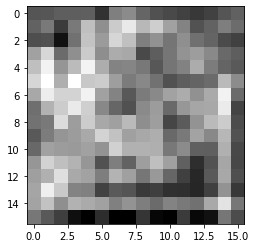

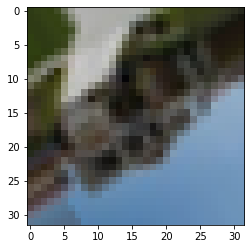

In [252]:
get_layer_output = K.function([model.input], model.layers[-1].output)

for X,Y in rotateDataset(x_test,y_test, batch_size=1, h=32, w=32, maxRot=360):
    print(Y)
    print(Y, np.argmax(model.predict(X)))
    #plt.imshow(X.reshape(28,28), cmap='gray_r')  
    plt.figure(1)  

    get_layer_output = K.function([model.input], model.layers[3].output)
    layer_out = np.array(get_layer_output([X]))
    print(layer_out.shape)
    plt.imshow(np.sum(layer_out[0,:,:,:], axis=-1),  cmap='gray_r')   
    #plt.figure(2) 

    #print(layer_out[0, :, : ,1 ].shape)
    #plt.imshow(layer_out[0, :, : ,1 ],  cmap='gray_r')

    plt.figure(3) 

    print(X.shape)
    plt.imshow(X[0],  cmap='gray_r')
    break

In [213]:
print(layer_out[0, :, :,:].shape)
yy =  tf.math.reduce_sum(layer_out[0, :, :, :], axis=-1, keepdims=True)
yy.shape


(8, 8, 256)


TensorShape([8, 8, 1])